In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,fbeta_score,roc_auc_score
reviews_train = pd.read_json('../data/processed/IMDB_reviews_train_cleaned.json')
reviews_test = pd.read_json('../data/processed/IMDB_reviews_test.json')

In [3]:
print(reviews_train.dtypes)
print(reviews_train.head)

review_date         int64
movie_id           object
user_id            object
is_spoiler           bool
review_text        object
rating_x            int64
review_summary     object
plot_summary       object
duration            int64
genre              object
rating_y          float64
release_date        int64
plot_synopsis      object
review_year         int64
review_month        int64
review_day          int64
release_year        int64
release_month       int64
release_day         int64
polarity          float64
subjectivity      float64
dtype: object
<bound method NDFrame.head of           review_date   movie_id     user_id  is_spoiler  \
407943  1156377600000  tt0463985  ur10173727       False   
171849  1430870400000  tt0790724   ur0453068       False   
557247  1132876800000  tt0160862   ur7395261        True   
374693  1147737600000  tt0388795   ur8323774       False   
546384  1324771200000  tt0120812  ur24340247        True   
...               ...        ...         ...      

In [4]:
print(reviews_train[['review_date','movie_id','user_id', 'is_spoiler', 'review_text', 'rating_x', 'review_summary', 'plot_summary', 'duration','genre', 'rating_y', 'release_date', 'plot_synopsis','polarity', 'subjectivity']].isnull().sum())
print(reviews_test[['review_date','movie_id','user_id', 'is_spoiler', 'review_text', 'rating_x', 'review_summary', 'plot_summary', 'duration','genre', 'rating_y', 'release_date', 'plot_synopsis','polarity', 'subjectivity']].isnull().sum())
#2 review summaries missing, 28032 plot_sypnopsis missing

#Drop NA values
reviews_train.dropna(subset=['review_summary','plot_synopsis'], inplace=True)
print(f"Data shape after dropping rows with null values: {reviews_train.shape}")

review_date           0
movie_id              0
user_id               0
is_spoiler            0
review_text           0
rating_x              0
review_summary        2
plot_summary          0
duration              0
genre                 0
rating_y              0
release_date          0
plot_synopsis     28032
polarity              0
subjectivity          0
dtype: int64
review_date       0
movie_id          0
user_id           0
is_spoiler        0
review_text       0
rating_x          0
review_summary    0
plot_summary      0
duration          0
genre             0
rating_y          0
release_date      0
plot_synopsis     0
polarity          0
subjectivity      0
dtype: int64
Data shape after dropping rows with null values: (431090, 21)


In [5]:
# Check the original distribution of the combined groups
group_counts = reviews_train.groupby(['is_spoiler']).size()
print("Original joint counts:\n", group_counts)

# Determine the minimum and maximum size for balancing all groups
min_group_size = group_counts.min()
max_group_size = group_counts.max()
print(f"\nTarget minimum sample size per joint group: {min_group_size}")
print(f"\nTarget maximum sample size per joint group: {max_group_size}")

# Undersample each train group to the minimum size found
undersampled_train = reviews_train.groupby(['is_spoiler']).apply(
    lambda x: x.sample(n=min_group_size, replace=False, random_state=3244)
).reset_index(drop=True)

print("Undersampled Train shape:", undersampled_train.shape)
print("New joint counts:\n", undersampled_train.groupby(['is_spoiler']).size())

# Undersample each test group to the minimum size found
test_group_counts = reviews_test.groupby(['is_spoiler']).size()
test_min_group_size = test_group_counts.min()
print(f"\nTest minimum sample size per joint group: {test_min_group_size}")
undersampled_test = reviews_test.groupby(['is_spoiler']).apply(
    lambda x: x.sample(n=test_min_group_size, replace=False, random_state=3244)
).reset_index(drop=True)

print("Undersampled Test shape:", undersampled_test.shape)
print("New joint counts:\n", undersampled_test.groupby(['is_spoiler']).size())


Original joint counts:
 is_spoiler
False    316468
True     114622
dtype: int64

Target minimum sample size per joint group: 114622

Target maximum sample size per joint group: 316468


/tmp/ipykernel_20/3786886414.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_train = reviews_train.groupby(['is_spoiler']).apply(


Undersampled Train shape: (229244, 21)
New joint counts:
 is_spoiler
False    114622
True     114622
dtype: int64

Test minimum sample size per joint group: 30056
Undersampled Test shape: (60112, 21)
New joint counts:
 is_spoiler
False    30056
True     30056
dtype: int64


/tmp/ipykernel_20/3786886414.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_test = reviews_test.groupby(['is_spoiler']).apply(


In [6]:
#Function to preprocess features
def process_X(data):
    df = data.copy()
    genre_text = df['genre'].apply(lambda x: ' '.join(x))
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['days_since_release'] = (df['review_date'] - df['release_date']).dt.days
    df['review'] = (df['review_text'] + ' ' + df['review_summary'] + ' ' + genre_text)
    df['plot'] = (df['plot_summary'] + ' '+ df['plot_synopsis'] + ' ' + genre_text)
    df = df.drop(columns=['is_spoiler','review_text','review_summary','plot_summary','plot_synopsis','review_date','release_date','release_year','release_month','release_day','review_year','review_month','review_day','movie_id','user_id'])
    return df

In [7]:
#Preprocess features
X_train = process_X(undersampled_train)
y_train = undersampled_train['is_spoiler']
X_test = process_X(undersampled_test)
y_test = undersampled_test['is_spoiler']

In [9]:
#Training model
preprocessor = ColumnTransformer(
    transformers=[('review_text', TfidfVectorizer(max_features= 10000), 'review'),
                  ('plot_text',TfidfVectorizer(max_features= 5000), 'plot'),
                  ('num', StandardScaler(), ['rating_x','rating_y','duration','polarity','subjectivity','days_since_release'])
                  ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver= 'saga',penalty ='l1', C=0.1,max_iter = 1000, random_state = 3244))
])

model.fit(X_train,y_train)

#Evaluation
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]

print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("F2-Score:", fbeta_score(y_test, y_pred, beta=2))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance:
Accuracy: 0.5753094224114985
F1-Score: 0.29076260591748854
F2-Score: 0.2073904393522665
ROC AUC: 0.7508266548304225

Classification Report:
              precision    recall  f1-score   support

       False       0.54      0.98      0.70     30056
        True       0.88      0.17      0.29     30056

    accuracy                           0.58     60112
   macro avg       0.71      0.58      0.49     60112
weighted avg       0.71      0.58      0.49     60112



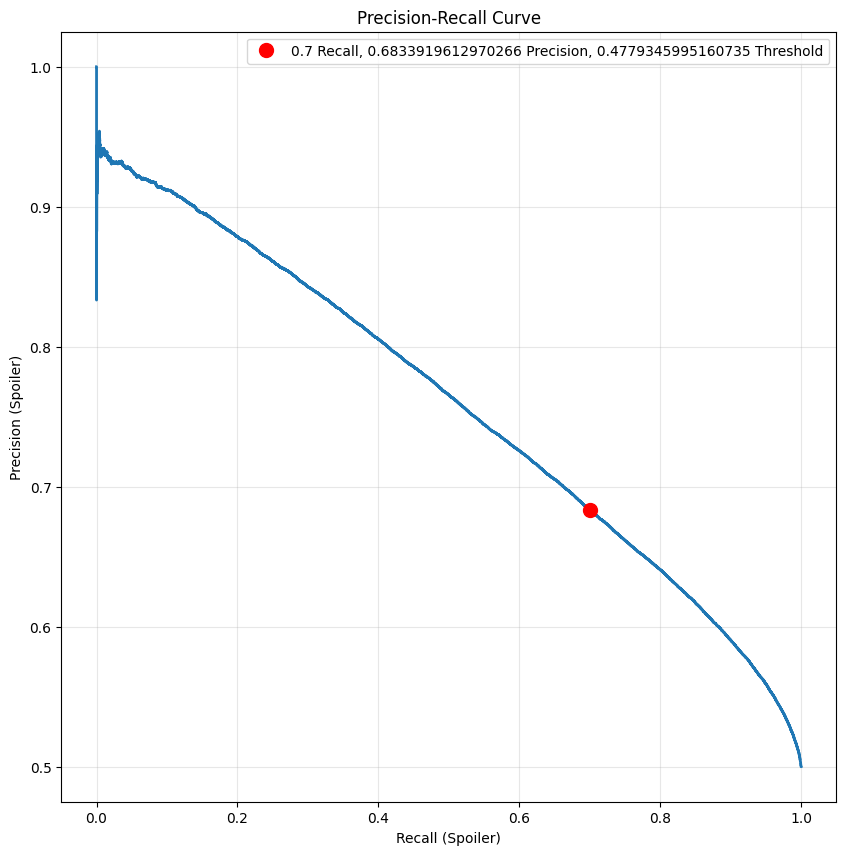

Validation Set Performance:
Optimal Threshold: 0.4779345995160735
Recall: 0.6999965102685348
Precision: 0.6833919612970266


In [10]:
#Plotting Precision-Recall curve to find threshold for recall>0.7 for spoilers
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, recall_score, precision_score
import matplotlib.pyplot as plt
y_cv_prob = cross_val_predict(model, X_train,y_train,cv=5,method ='predict_proba',n_jobs = 1)[:,1]
precision, recall, thresholds = precision_recall_curve(y_train, y_cv_prob)
target_recall = 0.7
recall_diff = np.abs(recall[:-1]- target_recall)
optimal_i = np.argmin(recall_diff)
optimal_threshold = thresholds[optimal_i]

plt.figure(figsize=(10,10))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall (Spoiler)')
plt.ylabel('Precision (Spoiler)')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.plot(recall[optimal_i],precision[optimal_i],'ro',markersize=10,label = f'0.7 Recall, {precision[optimal_i]} Precision, {optimal_threshold} Threshold')
plt.legend()
plt.show()

#Validation Set Performance
print(f"Validation Set Performance:")
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Recall: {recall[optimal_i]}")
print(f"Precision: {precision[optimal_i]}")

In [11]:
#Evaluation with new threshold
new_y_test_prob = model.predict_proba(X_test)[:,1]
new_y_test_pred = (new_y_test_prob> optimal_threshold).astype(int)
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, new_y_test_pred))
print("F1-Score:", f1_score(y_test, new_y_test_pred))
print("F2-Score:", fbeta_score(y_test, new_y_test_pred, beta=2))
print("ROC AUC:", roc_auc_score(y_test, new_y_test_prob))
print("\nClassification Report:")
print(classification_report(y_test, new_y_test_pred))


Model Performance:
Accuracy: 0.5864220122438115
F1-Score: 0.3303795081746438
F2-Score: 0.24089712871676028
ROC AUC: 0.7508266548304225

Classification Report:
              precision    recall  f1-score   support

       False       0.55      0.97      0.70     30056
        True       0.87      0.20      0.33     30056

    accuracy                           0.59     60112
   macro avg       0.71      0.59      0.52     60112
weighted avg       0.71      0.59      0.52     60112

